# Automating Trading Operations

## Capital Management

### Kelly Criterion in Binomial Setting

In [47]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import plt, mpl

np.random.seed(1000)
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

/tmp/ipykernel_47237/3635527203.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [48]:
p = 0.55

f = p - (1 - p)

I = 50
n = 100

In [49]:
def run_simulation(f):
    c = np.zeros((n, I))
    c[0] = 100
    for i in range(I):
        for t in range(1, n):
            o = np.random.binomial(1, p)
            if o > 0:
                c[t, i] = (1 + f) * c[t - 1, i]
            else:
                c[t, i] = (1 - f) * c[t - 1, i]
    return c

In [50]:
c_1 = run_simulation(f)
c_1

array([[100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [ 90.        , 110.        ,  90.        , ..., 110.        ,
         90.        , 110.        ],
       [ 99.        , 121.        ,  99.        , ..., 121.        ,
         81.        , 121.        ],
       ...,
       [226.35134536, 338.12978752, 413.2697403 , ..., 123.97455355,
        123.97455355, 123.97455355],
       [248.9864799 , 371.94276627, 454.59671433, ..., 136.3720089 ,
        136.3720089 , 136.3720089 ],
       [273.88512789, 409.1370429 , 409.1370429 , ..., 122.73480801,
        150.00920979, 122.73480801]])

In [51]:
c_1.round(2)

array([[100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ],
       [ 90.  , 110.  ,  90.  , ..., 110.  ,  90.  , 110.  ],
       [ 99.  , 121.  ,  99.  , ..., 121.  ,  81.  , 121.  ],
       ...,
       [226.35, 338.13, 413.27, ..., 123.97, 123.97, 123.97],
       [248.99, 371.94, 454.6 , ..., 136.37, 136.37, 136.37],
       [273.89, 409.14, 409.14, ..., 122.73, 150.01, 122.73]])

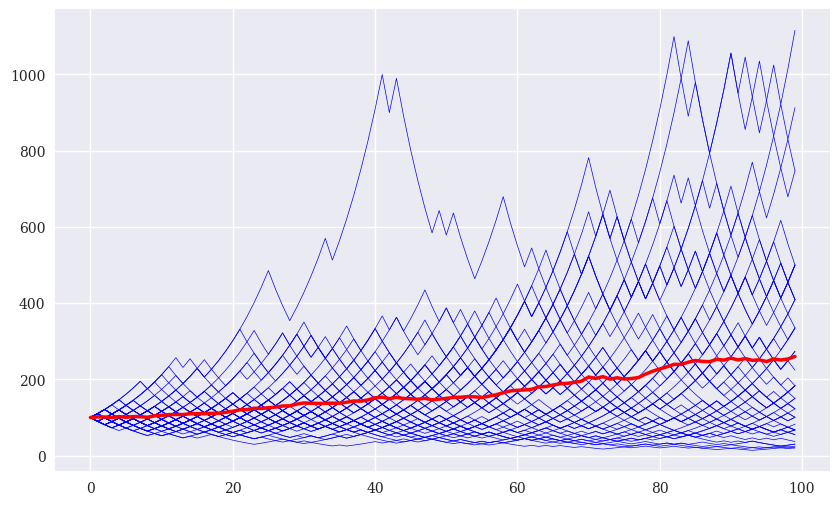

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(c_1, 'b', lw=0.5)
plt.plot(c_1.mean(axis=1), 'r', lw=2.5)

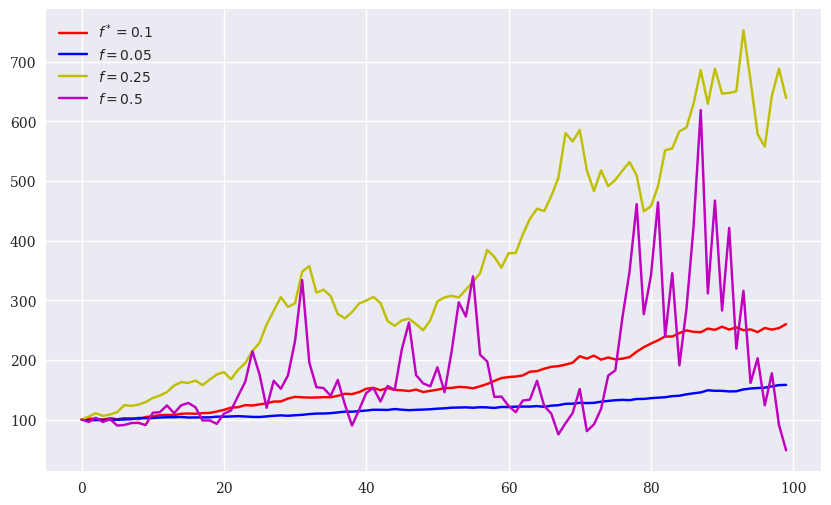

In [53]:
c_2 = run_simulation(0.05)
c_3 = run_simulation(0.25)
c_4 = run_simulation(0.5)

plt.figure(figsize=(10, 6))
plt.plot(c_1.mean(axis=1), 'r', label='$f^*=0.1$')
plt.plot(c_2.mean(axis=1), 'b', label='$f=0.05$')
plt.plot(c_3.mean(axis=1), 'y', label='$f=0.25$')
plt.plot(c_4.mean(axis=1), 'm', label='$f=0.5$')
plt.legend(loc=0)

### Kelly Criterion for Stocks and Indices

In [54]:
raw = pd.read_csv('./pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True)
raw.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82


In [55]:
symbol = '.SPX'
data = pd.DataFrame(raw[symbol])
data.head()

,.SPX
Date,
2010-01-01,NaN
2010-01-04,1132.99
2010-01-05,1136.52
2010-01-06,1137.14
2010-01-07,1141.69


In [56]:
data['return'] = np.log(data / data.shift(1))
data.dropna(inplace=True)
data.tail()

,.SPX,return
Date,,
2019-12-23,3224.01,0.000866
2019-12-24,3223.38,-0.000195
2019-12-27,3240.02,0.000034
2019-12-30,3221.29,-0.005798
2019-12-31,3230.78,0.002942


In [57]:
mu = data['return'].mean() * 252
mu

0.09992181916534204

In [58]:
sigma = data['return'].std() * 252 ** 0.5
sigma

0.14761569775486583

In [59]:
r = 0.0

kelly = (mu - r) / sigma ** 2
kelly

4.585590244019806

In [60]:
equs = []

def kelly_strategy(f):
    global equs
    equ = 'equity_{:.2f}'.format(f)
    equs.append(equ)
    cap = 'capital_{:.2f}'.format(f)
    data[equ] = 1
    data[cap] = data[equ] * f
    for i, t in enumerate(data.index[1:]):
        t_1 = data.index[i]
        data.loc[t, cap] = data[cap].loc[t_1] * \
                            math.exp(data['return'].loc[t])
        data.loc[t, equ] = data[cap].loc[t] - \
                            data[cap].loc[t_1] + \
                            data[equ].loc[t_1]
        data.loc[t, cap] = data[equ].loc[t] * f

In [61]:
kelly_strategy(f * 0.5)

In [62]:
kelly_strategy(f * 0.66)

In [63]:
kelly_strategy(f)

In [64]:
data[equs].tail()

,equity_0.05,equity_0.07,equity_0.10
Date,,,
2019-12-23,1.054485,1.072421,1.111358
2019-12-24,1.054475,1.072408,1.111336
2019-12-27,1.054477,1.072410,1.111340
2019-12-30,1.054172,1.072001,1.110697
2019-12-31,1.054327,1.072209,1.111024


<Axes: xlabel='Date'>

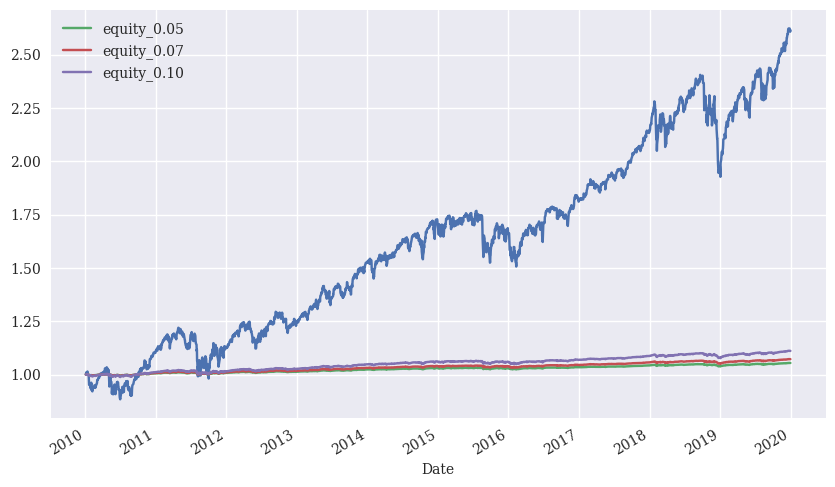

In [65]:
ax = data['return'].cumsum().apply(np.exp).plot(figsize=(10, 6))
data[equs].plot(ax=ax, legend=True)

## ML-Based Trading Strategy

### Vectorized Backtesting

In [66]:
import tpqoa

%time api = tpqoa.tpqoa('../pyalgo.cfg')

CPU times: user 1 ms, sys: 23 µs, total: 1.03 ms
Wall time: 998 µs


In [67]:
instrument = 'EUR_USD'

In [68]:
raw = api.get_history(instrument,
    start='2020-06-08',
    end='2020-06-13',
    granularity='M10',
    price='M')
raw.tail()

/home/mlopez/anaconda3/lib/python3.10/site-packages/urllib3/poolmanager.py:316: DeprecationWarning: The 'strict' parameter is no longer needed on Python 3+. This will raise an error in urllib3 v2.1.0.
  warnings.warn(


,o,h,l,c,volume,complete
time,,,,,,
2020-06-12 20:10:00,1.12572,1.12593,1.12532,1.12568,221,True
2020-06-12 20:20:00,1.12569,1.12578,1.12532,1.12558,163,True
2020-06-12 20:30:00,1.12560,1.12573,1.12534,1.12543,192,True
2020-06-12 20:40:00,1.12544,1.12594,1.12528,1.12542,219,True
2020-06-12 20:50:00,1.12544,1.12624,1.12541,1.12554,296,True


In [69]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2020-06-08 00:00:00 to 2020-06-12 20:50:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         701 non-null    float64
 1   h         701 non-null    float64
 2   l         701 non-null    float64
 3   c         701 non-null    float64
 4   volume    701 non-null    int64  
 5   complete  701 non-null    bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 33.5 KB


In [70]:
spread = 0.00012

In [71]:
mean = raw['c'].mean()
mean

1.132122738944365

In [72]:
ptc = spread / mean
ptc

0.00010599557439495706

<Axes: xlabel='time'>

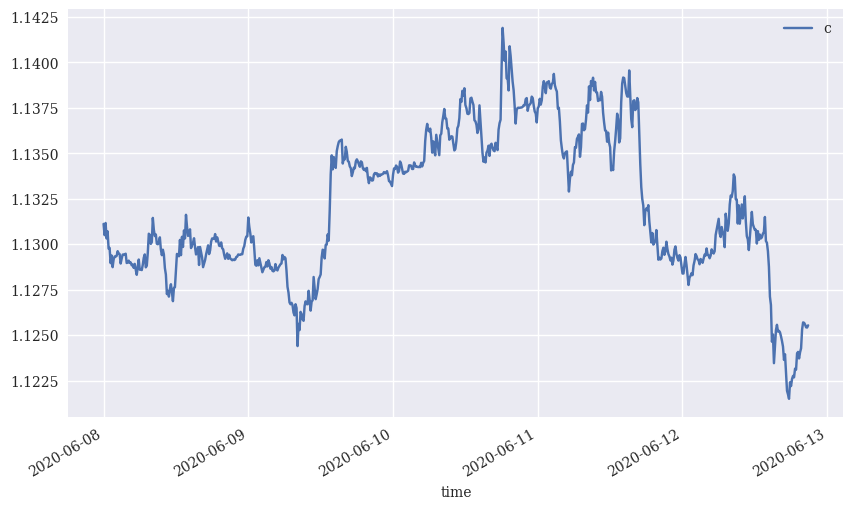

In [73]:
raw['c'].plot(figsize=(10, 6), legend=True)

In [74]:
data = pd.DataFrame(raw['c'])
data.columns = [instrument,]

data.tail()

,EUR_USD
time,
2020-06-12 20:10:00,1.12568
2020-06-12 20:20:00,1.12558
2020-06-12 20:30:00,1.12543
2020-06-12 20:40:00,1.12542
2020-06-12 20:50:00,1.12554


In [75]:
window = 20

data['return'] = np.log(data / data.shift(1))
data['vol'] = data['return'].rolling(window).std()
data['mom'] = np.sign(data['return'].rolling(window).mean())
data['sma'] = data[instrument].rolling(window).mean()
data['min'] = data[instrument].rolling(window).min()
data['max'] = data[instrument].rolling(window).max()

data.dropna(inplace=True)
data.tail()

,EUR_USD,return,vol,mom,sma,min,max
time,,,,,,,
2020-06-12 20:10:00,1.12568,-0.000018,0.000484,1.0,1.123392,1.1215,1.1257
2020-06-12 20:20:00,1.12558,-0.000089,0.000484,1.0,1.123473,1.1215,1.1257
2020-06-12 20:30:00,1.12543,-0.000133,0.000435,1.0,1.123596,1.1215,1.1257
2020-06-12 20:40:00,1.12542,-0.000009,0.000362,1.0,1.123770,1.1215,1.1257
2020-06-12 20:50:00,1.12554,0.000107,0.000354,1.0,1.123960,1.1215,1.1257


In [76]:
lags = 6
features = ['return', 'vol', 'mom', 'sma', 'min', 'max']

cols = []
for f in features:
    for lag in range(1, lags + 1):
        col = f'{f}_lag_{lag}'
        data[col] = data[f].shift(lag)
        cols.append(col)

data.dropna(inplace=True)
data.tail()

,EUR_USD,return,vol,mom,sma,min,max,return_lag_1,return_lag_2,return_lag_3,...,min_lag_3,min_lag_4,min_lag_5,min_lag_6,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,max_lag_6
time,,,,,,,,,,,,,,,,,,,,,
2020-06-12 20:10:00,1.12568,-0.000018,0.000484,1.0,1.123392,1.1215,1.1257,0.000347,0.000916,0.000196,...,1.1215,1.1215,1.1215,1.1215,1.1257,1.12531,1.12468,1.12494,1.12516,1.12524
2020-06-12 20:20:00,1.12558,-0.000089,0.000484,1.0,1.123473,1.1215,1.1257,-0.000018,0.000347,0.000916,...,1.1215,1.1215,1.1215,1.1215,1.1257,1.12570,1.12531,1.12468,1.12494,1.12516
2020-06-12 20:30:00,1.12543,-0.000133,0.000435,1.0,1.123596,1.1215,1.1257,-0.000089,-0.000018,0.000347,...,1.1215,1.1215,1.1215,1.1215,1.1257,1.12570,1.12570,1.12531,1.12468,1.12494
2020-06-12 20:40:00,1.12542,-0.000009,0.000362,1.0,1.123770,1.1215,1.1257,-0.000133,-0.000089,-0.000018,...,1.1215,1.1215,1.1215,1.1215,1.1257,1.12570,1.12570,1.12570,1.12531,1.12468
2020-06-12 20:50:00,1.12554,0.000107,0.000354,1.0,1.123960,1.1215,1.1257,-0.000009,-0.000133,-0.000089,...,1.1215,1.1215,1.1215,1.1215,1.1257,1.12570,1.12570,1.12570,1.12570,1.12531


In [77]:
data['direction'] = np.where(data['return'] > 0, 1, -1)
data[cols].iloc[:lags, :lags]

,return_lag_1,return_lag_2,return_lag_3,return_lag_4,return_lag_5,return_lag_6
time,,,,,,
2020-06-08 04:20:00,0.000097,0.000018,-0.000452,0.000035,0.000000,0.000009
2020-06-08 04:30:00,-0.000115,0.000097,0.000018,-0.000452,0.000035,0.000000
2020-06-08 04:40:00,0.000027,-0.000115,0.000097,0.000018,-0.000452,0.000035
2020-06-08 04:50:00,-0.000142,0.000027,-0.000115,0.000097,0.000018,-0.000452
2020-06-08 05:00:00,0.000035,-0.000142,0.000027,-0.000115,0.000097,0.000018
2020-06-08 05:10:00,-0.000159,0.000035,-0.000142,0.000027,-0.000115,0.000097


In [78]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [79]:
n_estimators=15
random_state=100
max_depth=2
min_samples_leaf=15
subsample=0.33

In [80]:
dtc = DecisionTreeClassifier(random_state=random_state,
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf)

In [81]:
# The idea of boosting in the context of classification is to use an ensemble of 
# base classifiers to arrive at a superior predictor that is supposed to be less prone to overfitting
model = AdaBoostClassifier(base_estimator=dtc,
                                   n_estimators=n_estimators,
                                   random_state=random_state)

In [82]:
split = int(len(data) * 0.7)
split

472

In [83]:
train = data.iloc[:split].copy()
train.tail()

,EUR_USD,return,vol,mom,sma,min,max,return_lag_1,return_lag_2,return_lag_3,...,min_lag_4,min_lag_5,min_lag_6,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,max_lag_6,direction
time,,,,,,,,,,,,,,,,,,,,,
2020-06-11 10:20:00,1.13792,-0.000026,0.000565,1.0,1.137713,1.13534,1.13916,0.000062,-0.000404,-0.000018,...,1.13481,1.13481,1.13481,1.13916,1.13916,1.13916,1.13916,1.13916,1.13916,-1
2020-06-11 10:30:00,1.13838,0.000404,0.000564,1.0,1.137865,1.13627,1.13916,-0.000026,0.000062,-0.000404,...,1.13481,1.13481,1.13481,1.13916,1.13916,1.13916,1.13916,1.13916,1.13916,1
2020-06-11 10:40:00,1.13812,-0.000228,0.000518,1.0,1.137940,1.13627,1.13916,0.000404,-0.000026,0.000062,...,1.13481,1.13481,1.13481,1.13916,1.13916,1.13916,1.13916,1.13916,1.13916,-1
2020-06-11 10:50:00,1.13724,-0.000774,0.000551,1.0,1.137970,1.13627,1.13916,-0.000228,0.000404,-0.000026,...,1.13481,1.13481,1.13481,1.13916,1.13916,1.13916,1.13916,1.13916,1.13916,-1
2020-06-11 11:00:00,1.13670,-0.000475,0.000557,1.0,1.137992,1.13634,1.13916,-0.000774,-0.000228,0.000404,...,1.13534,1.13481,1.13481,1.13916,1.13916,1.13916,1.13916,1.13916,1.13916,-1


In [84]:
mu, std = train.mean(), train.std()

In [85]:
train_ = (train - mu) / std

In [86]:
model.fit(train_[cols], train['direction'])

/home/mlopez/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=15,
                                                         random_state=100),
                   n_estimators=15, random_state=100)

In [87]:
# in-sample accuracy
accuracy_score(train['direction'], model.predict(train_[cols]))

0.8050847457627118

In [88]:
test = data.iloc[split:].copy()

In [89]:
test_ = (test - mu) / std

In [90]:
test['position'] = model.predict(test_[cols])

In [91]:
# out-of-sample accuracy
accuracy_score(test['direction'], test['position'])

0.5665024630541872

In [92]:
# taking costs into account
test['strategy'] = test['position'] * test['return']
sum(test['position'].diff() != 0)

77

In [93]:
test['strategy_tc'] = np.where(test['position'].diff() != 0,
                                        test['strategy'] - ptc,
                                        test['strategy'])

In [94]:
test[['return', 'strategy', 'strategy_tc']].sum(
                 ).apply(np.exp)

return         0.990182
strategy       1.015827
strategy_tc    1.007570
dtype: float64

<Axes: xlabel='time'>

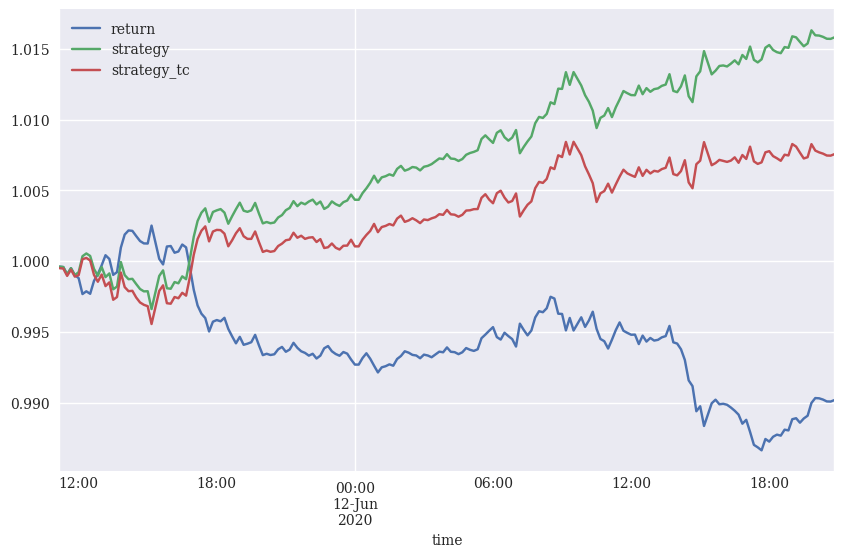

In [95]:
test[['return', 'strategy', 'strategy_tc']].cumsum(
                 ).apply(np.exp).plot(figsize=(10, 6))

### Optimal Leverage

In [96]:
mean = test[['return', 'strategy_tc']].mean() * len(data) * 52
mean

return        -1.705965
strategy_tc    1.304023
dtype: float64

In [97]:
var = test[['return', 'strategy_tc']].var() * len(data) * 52
var

return         0.011306
strategy_tc    0.011370
dtype: float64

In [98]:
vol = var ** 0.5
vol

return         0.106332
strategy_tc    0.106631
dtype: float64

In [99]:
mean / var

return        -150.884961
strategy_tc    114.687875
dtype: float64

In [100]:
mean / var * 0.5

return        -75.442481
strategy_tc    57.343938
dtype: float64

<Axes: xlabel='time'>

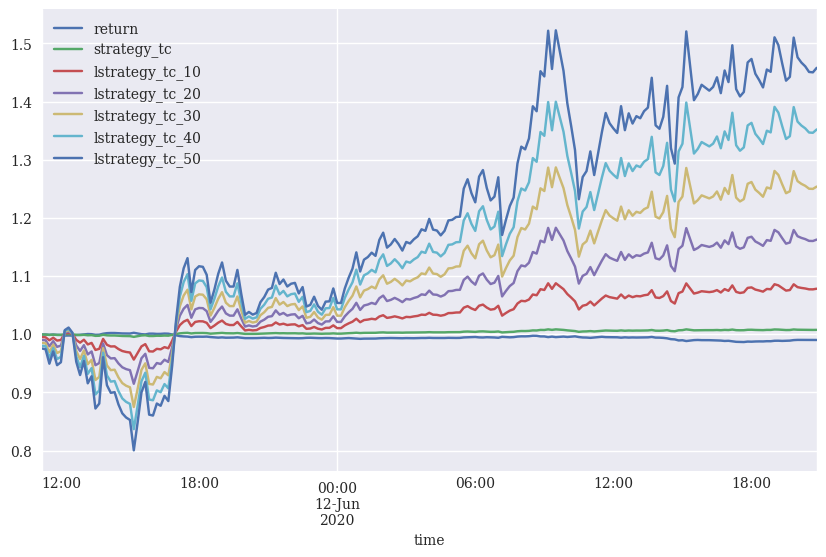

In [101]:
to_plot = ['return', 'strategy_tc']

for lev in [10, 20, 30, 40, 50]:
    label = 'lstrategy_tc_%d' % lev
    test[label] = test['strategy_tc'] * lev
    to_plot.append(label)

test[to_plot].cumsum().apply(np.exp).plot(figsize=(10, 6))

### Risk Analysis

In [102]:
# The risk analysis that follows assumes a leverage ratio of 30.
# Maximum drawdown is the largest loss (dip) after a recent high.
# Longest drawdown period is the longest period the trading strategy needs to get back to a recent high

"""
The analysis assumes that the initial equity position is 3,333 EUR leading to an initial 
position size of 100,000 EUR for a leverage ratio of 30.
"""

equity = 3333

risk = pd.DataFrame(test['lstrategy_tc_30'])
risk['equity'] = risk['lstrategy_tc_30'].cumsum().apply(np.exp) * equity
risk['cummax'] = risk['equity'].cummax()
risk['drawdown'] = risk['cummax'] - risk['equity']
risk['drawdown'].max()

511.38321383258017

In [103]:
t_max = risk['drawdown'].idxmax()
t_max

Timestamp('2020-06-12 10:30:00')

In [104]:
# Technically, a new high is characterized by a drawdown value of 0.
temp = risk['drawdown'][risk['drawdown'] == 0]
periods = (temp.index[1:].to_pydatetime() - temp.index[:-1].to_pydatetime())
periods[20:30]

array([datetime.timedelta(seconds=600), datetime.timedelta(seconds=1200),
       datetime.timedelta(seconds=1200), datetime.timedelta(seconds=1200)],
      dtype=object)

In [105]:
t_per = periods.max()
t_per

datetime.timedelta(seconds=26400)

In [106]:
t_per.seconds / 60 / 60

7.333333333333333

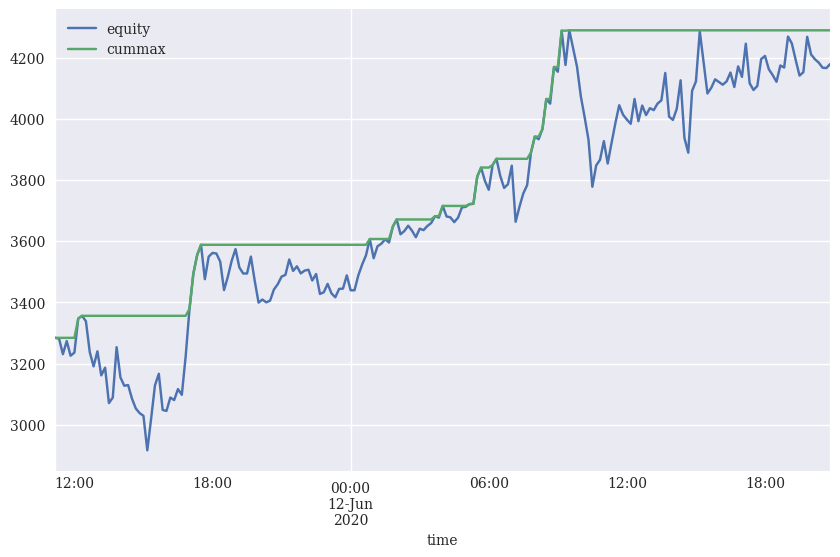

In [107]:
risk[['equity', 'cummax']].plot(figsize=(10, 6))
plt.axvline(t_max, c='r', alpha=0.5)

In [108]:
"""
Another important risk measure is value-at-risk (VaR). 
It is quoted as a currency amount and represents the maximum loss to be expected 
given both a certain time horizon and a confidence level.
"""

import scipy.stats as scs

percentiles = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
risk['return'] = np.log(risk['equity'] /
                                  risk['equity'].shift(1))
VaR = scs.scoreatpercentile(equity * risk['return'], percentiles)

def print_var(VaR):
    print('{}    {}'.format('Confidence Level', 'Value-at-Risk'))
    print(33 * '-')
    for pair in zip(percentiles, VaR):
        print('{:16.2f} {:16.3f}'.format(100 - pair[0], -pair[1]))

print_var(VaR)

Confidence Level    Value-at-Risk
---------------------------------
           99.99          162.570
           99.90          161.348
           99.00          132.382
           97.50          122.913
           95.00          100.950
           90.00           62.622


In [109]:
"""
Finally, the following code calculates the VaR values for a time horizon of 
one hour by resampling the original DataFrame object.
"""

hourly = risk.resample('1H', label='right').last()
hourly['return'] = np.log(hourly['equity'] /
                                   hourly['equity'].shift(1))
VaR = scs.scoreatpercentile(equity * hourly['return'], percentiles)

print_var(VaR)

Confidence Level    Value-at-Risk
---------------------------------
           99.99          252.460
           99.90          251.744
           99.00          244.593
           97.50          232.674
           95.00          125.498
           90.00           61.701


### Persisting the Model Object

In [110]:
import pickle

algorithm = {'model': model, 'mu': mu, 'std': std}
pickle.dump(algorithm, open('algorithm.pkl', 'wb'))

/tmp/ipykernel_47237/2940497507.py:4: ResourceWarning: unclosed file <_io.BufferedWriter name='algorithm.pkl'>
  pickle.dump(algorithm, open('algorithm.pkl', 'wb'))


## Online Algorithm

In [111]:
algorithm = pickle.load(open('algorithm.pkl', 'rb'))
algorithm['model']

/tmp/ipykernel_47237/1162401938.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='algorithm.pkl'>
  algorithm = pickle.load(open('algorithm.pkl', 'rb'))


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=15,
                                                         random_state=100),
                   n_estimators=15, random_state=100)

In [112]:
class MLTrader(tpqoa.tpqoa):
    def __init__(self, config_file, algorithm):
        super(MLTrader, self).__init__(config_file)
        self.model = algorithm['model']
        self.mu = algorithm['mu']
        self.std = algorithm['std']
        self.units = 100000
        self.position = 0
        self.bar = '5s'
        self.window = 2
        self.lags = 6
        self.min_length = self.lags + self.window + 1
        self.features = ['return', 'sma', 'min', 'max', 'vol', 'mom']
        self.raw_data = pd.DataFrame()

    def prepare_features(self):
        self.data['return'] = np.log(self.data['mid'] /
                                    self.data['mid'].shift(1))
        self.data['sma'] = self.data['mid'].rolling(self.window).mean()
        self.data['min'] = self.data['mid'].rolling(self.window).min()
        self.data['mom'] = np.sign(
            self.data['return'].rolling(self.window).mean())
        self.data['max'] = self.data['mid'].rolling(self.window).max()
        self.data['vol'] = self.data['return'].rolling(
            self.window).std()
        self.data.dropna(inplace=True)
        self.data[self.features] -= self.mu
        self.data[self.features] /= self.std
        self.cols = []
        for f in self.features:
            for lag in range(1, self.lags + 1):
                col = f'{f}_lag_{lag}'
                self.data[col] = self.data[f].shift(lag)
                self.cols.append(col)

    def on_success(self, time, bid, ask):
        df = pd.DataFrame({'bid': float(bid), 'ask': float(ask)},
                        index=[pd.Timestamp(time).tz_localize(None)])
        self.raw_data = self.raw_data.append(df)
        self.data = self.raw_data.resample(self.bar,
                                label='right').last().ffill()
        self.data = self.data.iloc[:-1]
        if len(self.data) > self.min_length:
            self.min_length +=1
            self.data['mid'] = (self.data['bid'] +
                                self.data['ask']) / 2
            self.prepare_features()
            features = self.data[
                self.cols].iloc[-1].values.reshape(1, -1)
            signal = self.model.predict(features)[0]
            print(f'NEW SIGNAL: {signal}', end='\r')
            if self.position in [0, -1] and signal == 1:
                print('*** GOING LONG ***')
                self.create_order(self.stream_instrument,
                            units=(1 - self.position) * self.units)
                self.position = 1
            elif self.position in [0, 1] and signal == -1: 
                print('*** GOING SHORT ***')
                self.create_order(self.stream_instrument,
                            units=-(1 + self.position) * self.units)
                self.position = -1

In [113]:
mlt = MLTrader('../pyalgo.cfg', algorithm)
mlt.stream_data(instrument, stop=5)

/home/mlopez/anaconda3/lib/python3.10/site-packages/urllib3/poolmanager.py:316: DeprecationWarning: The 'strict' parameter is no longer needed on Python 3+. This will raise an error in urllib3 v2.1.0.
  warnings.warn(
/tmp/ipykernel_47237/1299665891.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.raw_data = self.raw_data.append(df)
/tmp/ipykernel_47237/1299665891.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.raw_data = self.raw_data.append(df)
/tmp/ipykernel_47237/1299665891.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.raw_data = self.raw_data.append(df)
/tmp/ipykernel_47237/1299665891.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v